# Using netgraph for visualization

Import annotations.

In [3]:
import json
import zipfile
from io import TextIOWrapper

path = '../../dgym-data/analysis/noise/selection_noise_2024-05-10_23-36-56_continued.zip'
with zipfile.ZipFile(path, 'r') as z:
    for filename in z.namelist()[200:201]:
        with z.open(filename) as file:
            with TextIOWrapper(file, encoding='utf-8') as text_file:
                result = json.load(text_file)

In [7]:
import pandas as pd

df = pd.DataFrame(result['annotations']).reindex(
    columns=['SMILES', 'Inspiration', 'Current Status', 'Step Made', 'ABL1 pIC50', 'Log P', 'Log S'])

tested_adjacency = df[['Inspiration', 'SMILES']]
tested_adjacency = tested_adjacency.dropna().values

Get utility

In [25]:
from dgym.envs.utility import MultipleUtilityFunction, ClassicUtilityFunction

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    ideal=(9, 13),
    acceptable=(8, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    ideal=(-0.5, 3.5),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    ideal=(-4, 1),
    acceptable=(-4, 1)
)

composite_utility_function = MultipleUtilityFunction(
    utility_functions = [docking_utility_function, log_P_utility_function, log_S_utility_function],
    weights = [0.8, 0.1, 0.1]
)

df['utility'] = composite_utility_function(
    df[['ABL1 pIC50', 'Log P', 'Log S']].values, precompute=True, method='average'
)

In [26]:
import numpy as np
best_utility = -np.inf
best_properties = []
for idx, row in df.dropna().iterrows():
    if row['utility'] > best_utility:
        best_properties.append(row[['ABL1 pIC50', 'Log P', 'Log S']])
        best_utility = row['utility']

/tmp/ipykernel_606278/2285632490.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Greys')
/tmp/ipykernel_606278/2285632490.py:48: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("blue")
/tmp/ipykernel_606278/2285632490.py:50: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color("blue")
/tmp/ipykernel_606278/2285632490.py:52: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color("blue")
/tmp/ipykernel_606278/2285632490.py:54: MatplotlibDeprecationWarning: The w_xaxis attribu

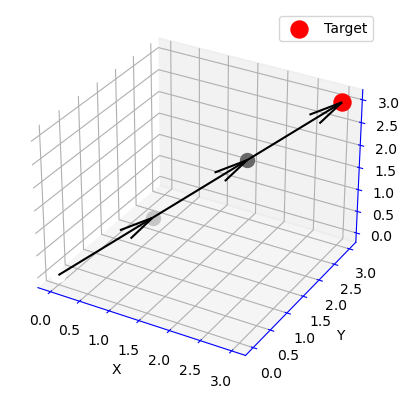

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot_3d_points_with_arrows(points, target):
    """
    Plots 3D points with large grey dots and arrows pointing from old to new dots.
    Dots get darker as they get closer to the target point.
    
    Parameters
    ----------
    points : np.ndarray
        A 2D numpy array of shape (n, 3) representing the 3D points.
    target : np.ndarray
        A 1D numpy array of shape (3,) representing the target point.
    """
    # Calculate distances from points to the target
    distances = np.linalg.norm(points - target, axis=1)
    
    # Normalize distances for colormap
    norm_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
    
    # Create a colormap
    cmap = cm.get_cmap('Greys')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(len(points)):
        color = cmap(1 - norm_distances[i])  # Color gets darker as distance decreases
        ax.scatter(points[i, 0], points[i, 1], points[i, 2], color=color, s=100)
        
        if i > 0:
            ax.quiver(points[i-1, 0], points[i-1, 1], points[i-1, 2], 
                      points[i, 0] - points[i-1, 0], 
                      points[i, 1] - points[i-1, 1], 
                      points[i, 2] - points[i-1, 2], 
                      color='black')
    
    ax.scatter(target[0], target[1], target[2], color='red', s=150, label='Target')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Change axis colors
    ax.w_xaxis.line.set_color("blue")
    [t.set_color('blue') for t in ax.xaxis.get_ticklines()]
    ax.w_yaxis.line.set_color("blue")
    [t.set_color('blue') for t in ax.yaxis.get_ticklines()]
    ax.w_zaxis.line.set_color("blue")
    [t.set_color('blue') for t in ax.zaxis.get_ticklines()]
    
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.legend()
    plt.show()

# Example usage
points = np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2], [3, 3, 3]])
target = np.array([3, 3, 3])
plot_3d_points_with_arrows(points, target)

/tmp/ipykernel_606278/2734454584.py:69: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color("blue")
/tmp/ipykernel_606278/2734454584.py:71: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color("blue")
/tmp/ipykernel_606278/2734454584.py:73: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color("blue")


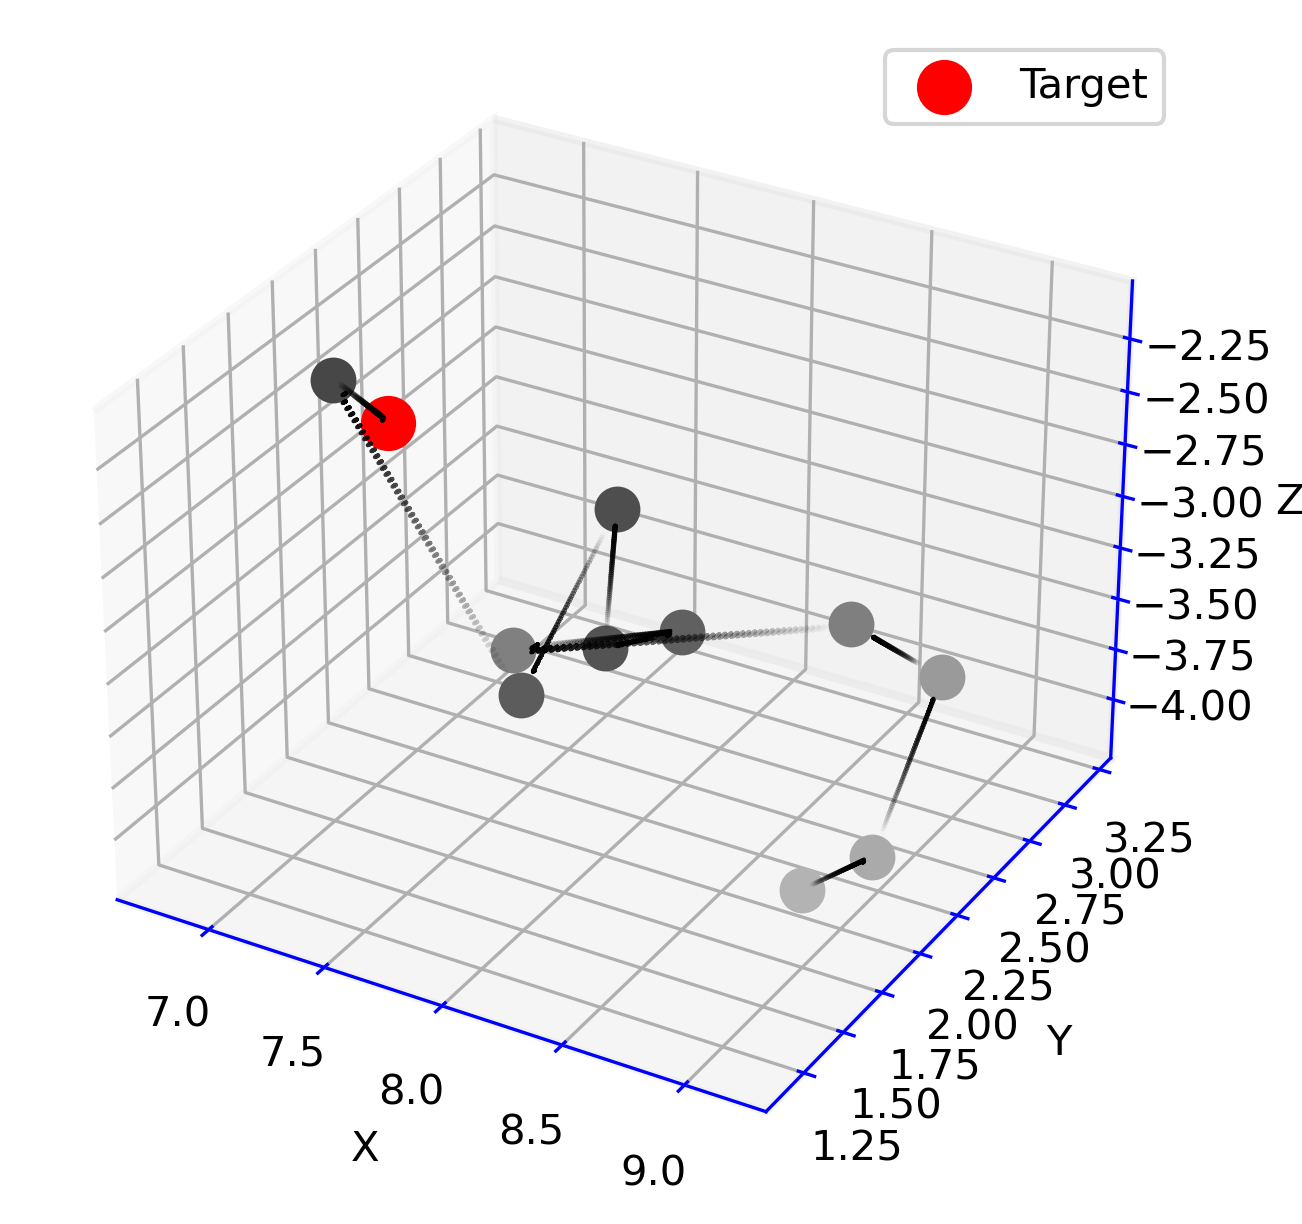

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

def plot_3d_points_with_arrows(points, target, margin=0.1):
    """
    Plots 3D points with large grey dots and arrows pointing from old to new dots.
    Dots get darker as they get closer to the target point. Arrows have a margin
    and a gradient effect.
    
    Parameters
    ----------
    points : np.ndarray
        A 2D numpy array of shape (n, 3) representing the 3D points.
    target : np.ndarray
        A 1D numpy array of shape (3,) representing the target point.
    margin : float
        A margin to separate arrows from the dots.
    """
    # Calculate distances from points to the target
    distances = np.linalg.norm(points - target, axis=1)
    
    # Normalize distances for colormap
    norm_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))
    
    # Create a colormap
    cdict = {'red':   [(0.0, 0.7, 0.7),
                       (1.0, 0.0, 0.0)],
             'green': [(0.0, 0.7, 0.7),
                       (1.0, 0.0, 0.0)],
             'blue':  [(0.0, 0.7, 0.7),
                       (1.0, 0.0, 0.0)]}
    
    cmap = LinearSegmentedColormap('custom_grey', cdict)
    # cmap = cm.get_cmap('Greys')
    
    fig = plt.figure(figsize=(10, 5), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    
    for i in range(len(points)):
        color = cmap(1 - norm_distances[i])  # Color gets darker as distance decreases
        ax.scatter(points[i, 0], points[i, 1], points[i, 2], color=color, s=100)
        
        if i > 0:
            start_point = points[i-1]
            end_point = points[i]
            direction = end_point - start_point
            length = np.linalg.norm(direction)
            unit_direction = direction / length
            
            # Adjust start and end points for margin
            adjusted_start = start_point + margin * unit_direction
            adjusted_end = end_point - margin * unit_direction
            draw_gradient_arrow(ax, adjusted_start, adjusted_end, num_segments=50)
    
    ax.scatter(target[0], target[1], target[2], color='red', s=150, label='Target')
    
    # Set axis labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    # Change axis colors
    ax.w_xaxis.line.set_color("blue")
    [t.set_color('blue') for t in ax.xaxis.get_ticklines()]
    ax.w_yaxis.line.set_color("blue")
    [t.set_color('blue') for t in ax.yaxis.get_ticklines()]
    ax.w_zaxis.line.set_color("blue")
    [t.set_color('blue') for t in ax.zaxis.get_ticklines()]
    ax.xaxis.pane.set_linewidth(2)
    ax.yaxis.pane.set_linewidth(2)
    ax.zaxis.pane.set_linewidth(2)
    
    plt.show()

def draw_gradient_arrow(ax, start, end, num_segments=100):
    """
    Draws a 3D arrow with a gradient from transparent to opaque.
    
    Parameters
    ----------
    ax : Axes3D
        The 3D axis to plot on.
    start : np.ndarray
        The start point of the arrow.
    end : np.ndarray
        The end point of the arrow.
    num_segments : int
        The number of segments to use for the gradient effect.
    """
    direction = end - start
    length = np.linalg.norm(direction)
    unit_direction = direction / length
    
    for i in range(num_segments):
        alpha = i / num_segments
        color = (0, 0, 0, alpha)  # Use RGBA to set transparency
        segment_start = start + alpha * direction
        segment_end = start + (alpha + 1/num_segments) * direction
        arrow = FancyArrowPatch(
            segment_start[:2],
            segment_end[:2],
            color=color,
            mutation_scale=100,
            # arrowstyle='-|>'
        )
        ax.add_patch(arrow)
        art3d.patch_2d_to_3d(arrow, z=segment_start[2], zdir="z")
    
    # Add a triangular arrowhead at the end
    arrow_length = length / num_segments
    arrow = FancyArrowPatch(
        (end - arrow_length * unit_direction)[:2],
        end[:2],
        color='black',
        mutation_scale=100,
        # arrowstyle='->'
    )
    ax.add_patch(arrow)
    art3d.patch_2d_to_3d(arrow, z=end[2], zdir="z")

# Example usage
points = pd.DataFrame(best_properties).values[::-1]
plot_3d_points_with_arrows(points, target=pd.DataFrame(best_properties).values[0])